# Preliminary

L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

## Imports 

In [162]:
import os
import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import missingno as msno
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import tarfile
import sklearn
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import save_img

print(os.getcwd())
print("Numpy : {}".format(np.__version__))
print("Pandas : {}".format(pd.__version__))
print("Missingno Version : {}".format(msno.__version__))
print("Matplotlib Version : {}".format(matplotlib.__version__))
print("Seaborn Version : {}".format(sns.__version__))
print("Scikit-Learn Version : {}".format(sklearn.__version__))

C:\Users\Lemel\OPC-P6
Numpy : 1.23.5
Pandas : 1.5.3
Missingno Version : 0.4.2
Matplotlib Version : 3.7.0
Seaborn Version : 0.12.2
Scikit-Learn Version : 1.2.1


# Fonctions

In [114]:
def shape2(df):
    """
    Analyzes the shape of the dataframe: 1) Open it, give some infos 2) Nan values 3) Describe method
    """

    # Head & tail
    df_combined = pd.concat([df.head(), df.tail()], axis=0)
    display(df_combined)
    print("\nNumber of Rows: ", df.shape[0])
    print("Number of Columns: ", df.shape[1])

    for col in df.columns:
            print("Column {}: {}".format(col, df[col].dtype))

    for col in df.columns:
            print("\nUnique values in {}:".format(col))
            print(df[col].unique())

    # N_unique values
    nunique_dict = {col: df[col].nunique() for col in df.columns}
    nunique_df = pd.DataFrame.from_dict(nunique_dict, orient='index', columns=['N_unique values'])
    display(nunique_df)

    # Value counts and missing/duplicated data
    if 'type' in df.columns:
        print("\nValue counts of 'type':")
        print(df['type'].value_counts())
    else:
        print("\n'type' column not found in dataframe.")
    print("\nNumber of missing values:")
    print(df.isna().sum())
    print("\nNumber of duplicated rows:")
    print(df.duplicated().sum())

    # Seaborn heatmap
    print("\nSeaborn heatmap:")
    sns.heatmap(df.isnull(), cmap='viridis')
    plt.show()

In [115]:
def shape3(df):
    """
    Analyzes the shape of the dataframe: 1) Open it, give some infos 2) Nan values 3) Describe method
    """

    # Head & tail
    df_combined = pd.concat([df.head(), df.tail()], axis=0)
    display(df_combined)
    print("\nNumber of Rows: ", df.shape[0])
    print("Number of Columns: ", df.shape[1])

    for col in df.columns:
            print("Column {}: {}".format(col, df[col].dtype))

    for col in df.columns:
        if col == '_Tags':
            print("\nUnique values in {}:".format(col))
            unique_tags = set(tag for tag_list in df[col] for tag in tag_list)
            print(unique_tags)
        else:
            print("\nUnique values in {}:".format(col))
            print(df[col].unique())

    # N_unique values
    nunique_dict = {}
    for col in df.columns:
        if col == '_Tags':
            nunique_dict[col] = len(set(tag for tag_list in df[col] for tag in tag_list))
        else:
            nunique_dict[col] = df[col].nunique()

    nunique_df = pd.DataFrame.from_dict(nunique_dict, orient='index', columns=['N_unique values'])
    display(nunique_df)

    # Value counts and missing/duplicated data
    if 'type' in df.columns:
        print("\nValue counts of 'type':")
        print(df['type'].value_counts())
    else:
        print("\n'type' column not found in dataframe.")
    print("\nNumber of missing values:")
    print(df.isna().sum())

    # Check duplicates with _Tags as strings
    df_temp = df.copy()
    df_temp['_Tags'] = df_temp['_Tags'].apply(lambda x: str(x))
    print("\nNumber of duplicated rows:")
    print(df_temp.duplicated().sum())

    # Seaborn heatmap
    print("\nSeaborn heatmap:")
    sns.heatmap(df.isnull(), cmap='viridis')
    plt.show()

# Ouverture du dataset

In [116]:
# Data acces

path = "C:\\Users\\Lemel\\OPC-P6"
tar_path = "C:\\Users\\Lemel\\OPC-P6\\images.tar"
extract_path = "C:\\Users\\Lemel\\OPC-P6\\images"

# tarfile.open() to open the file
with tarfile.open(tar_path) as tar:
    # extract the contents of the tar file
    tar.extractall(path=extract_path)
    # Get the list of files in the tar file
    files = tar.getnames()

# Print the number of files
print("Number of files:", len(files))

Number of files: 20701


In [117]:
# Data acces
images_dir = os.path.join(extract_path, "Images")

# Get a list of all the breed directories
breeds = os.listdir(images_dir)

# Initialize a list 
data = []

# Loop over each breed
for breed in breeds:
    # Get a list of all the images for this breed
    images = os.listdir(os.path.join(images_dir, breed))
    # Append the breed and the number of images to the data list
    data.append([breed, len(images)])

# Convert the data list to a DataFrame
df = pd.DataFrame(data, columns=['Breed', 'Number of Images'])

# Print the total number of breeds
print("Total number of breeds:", len(breeds))

Total number of breeds: 120


In [118]:
# Représentartion rapide
df.head()

,Breed,Number of Images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214


,Breed,Number of Images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214
115,n02113799-standard_poodle,159
116,n02113978-Mexican_hairless,155
117,n02115641-dingo,156
118,n02115913-dhole,150
119,n02116738-African_hunting_dog,169



Number of Rows:  120
Number of Columns:  2
Column Breed: object
Column Number of Images: int64

Unique values in Breed:
['n02085620-Chihuahua' 'n02085782-Japanese_spaniel'
 'n02085936-Maltese_dog' 'n02086079-Pekinese' 'n02086240-Shih-Tzu'
 'n02086646-Blenheim_spaniel' 'n02086910-papillon' 'n02087046-toy_terrier'
 'n02087394-Rhodesian_ridgeback' 'n02088094-Afghan_hound'
 'n02088238-basset' 'n02088364-beagle' 'n02088466-bloodhound'
 'n02088632-bluetick' 'n02089078-black-and-tan_coonhound'
 'n02089867-Walker_hound' 'n02089973-English_foxhound' 'n02090379-redbone'
 'n02090622-borzoi' 'n02090721-Irish_wolfhound'
 'n02091032-Italian_greyhound' 'n02091134-whippet'
 'n02091244-Ibizan_hound' 'n02091467-Norwegian_elkhound'
 'n02091635-otterhound' 'n02091831-Saluki' 'n02092002-Scottish_deerhound'
 'n02092339-Weimaraner' 'n02093256-Staffordshire_bullterrier'
 'n02093428-American_Staffordshire_terrier' 'n02093647-Bedlington_terrier'
 'n02093754-Border_terrier' 'n02093859-Kerry_blue_terrier'
 'n020

,N_unique values
Breed,120
Number of Images,49



'type' column not found in dataframe.

Number of missing values:
Breed               0
Number of Images    0
dtype: int64

Number of duplicated rows:
0

Seaborn heatmap:


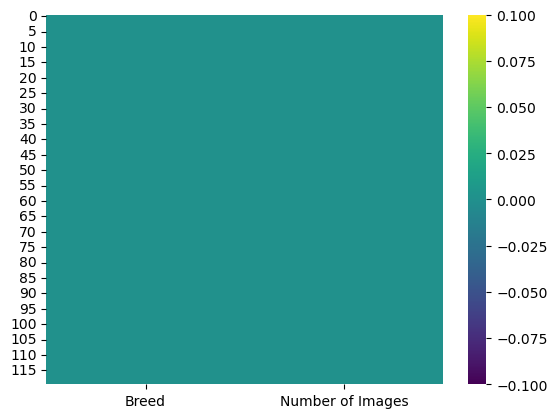

In [119]:
# Ici nous avons la liste de toutes les races 
shape2(df)

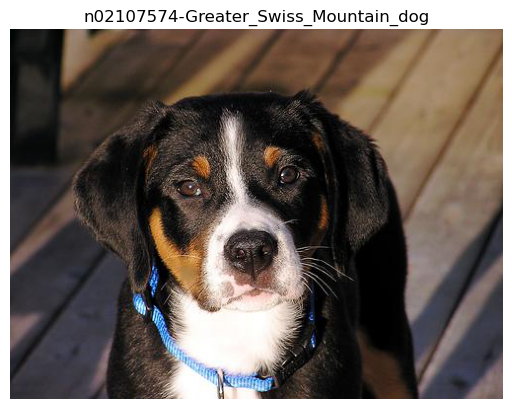

In [120]:
# Random example ; each time.
random_breed = random.choice(breeds)

# Get a list of all images for this 'breed example'
images = os.listdir(os.path.join(images_dir, random_breed))

# Choose a random image from this 'breed example'
random_image = random.choice(images)

# Create the full path to the image example
example_image_path = os.path.join(images_dir, random_breed, random_image)

# Load the image
img = mpimg.imread(example_image_path)

# Display the image
plt.imshow(img)
plt.title(random_breed)
plt.axis('off')  # to hide the axis
plt.show()

# Filtering the 15 most commons breed in the dataset 

In [121]:
# Sort the DataFrame by 'Number of Images' in descending order and take the first 15 rows
top_breeds_df = df.sort_values('Number of Images', ascending=False).head(15)

# Get the breed names as a list
top_breeds = top_breeds_df['Breed'].tolist()

print(top_breeds)

['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier', 'n02095889-Sealyham_terrier', 'n02108000-EntleBucher', 'n02096051-Airedale']


In [122]:
def load_and_filter_images(breeds, directory):
    data = []
    # Loop over each breed
    for breed in breeds:
        # Get a list of all the images for this breed
        images = os.listdir(os.path.join(directory, breed))
        # Append the breed and the images to the data list
        for image in images:
            # Full path to the image
            image_path = os.path.join(directory, breed, image)
            data.append([breed, image_path])
    return data

In [123]:
# Use the function
data = load_and_filter_images(top_breeds, images_dir)

# Convert the data list to a DataFrame
filtered_df = pd.DataFrame(data, columns=['Breed', 'Image'])

In [124]:
filtered_df.nunique()

Breed      15
Image    3254
dtype: int64

# Pictures Pre-processing with 

**OPC : Dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).**

*Dans un deuxième temps, nous sauvegardons les images dans un nouveau répertoire pour une utilisation ultérieure avec un CNN* 

## ImageDataGenerator

**Preprocessing of images with specific techniques:** 

Whitening: This is done with ImageDataGenerator by setting the zca_whitening parameter to True. ZCA Whitening is a technique used to reduce the redundancy in the matrix of pixel images, and it helps in highlighting the structure and features of the images.

Resizing: The target_size parameter of the flow_from_directory method is used to resize all the images to a consistent size (in our case, we choose 180x180 pixels).

Normalization: This is done by setting the rescale parameter to 1./255 in ImageDataGenerator. Values range : [0, 1].

*Equalization:  Image equalization is usually used to improve the contrast of the image. Keras' ImageDataGenerator doesn't offer this function out of the box. This operation can be implemented with OpenCV.*

**Data Augmentation:**

Mirroring: set horizontal_flip to True in ImageDataGenerator.

Rotation, Zooming, and Shifting: set rotation_range, zoom_range, width_shift_range, and height_shift_range in ImageDataGenerator. *It's not really useful in our case*

*Cropping: Unfortunately, this is not included in the ImageDataGenerator function of Keras. ! cropping might cut off important parts of the dog!

In [125]:
# Set the directory where the images are
images_dir = os.path.join(extract_path, "Images")

In [126]:
# Define directory
directory = images_dir

In [160]:
# Les images ne sont pas toutes à la même taille!

batch_size = 32
img_height = 180
img_width = 180

In [166]:
# Initialize the ImageDataGenerator with more augmentations
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    zca_whitening=True,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    validation_split=0.2)  # use 20% of the data for validation

# Use flow_from_dataframe method
train_it = datagen.flow_from_dataframe(
    dataframe=filtered_df,
    directory=directory,
    x_col="Image",
    y_col="Breed",
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

val_it = datagen.flow_from_dataframe(
    dataframe=filtered_df,
    directory=directory,
    x_col="Image",
    y_col="Breed",
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)

Found 2604 validated image filenames belonging to 15 classes.
Found 650 validated image filenames belonging to 15 classes.


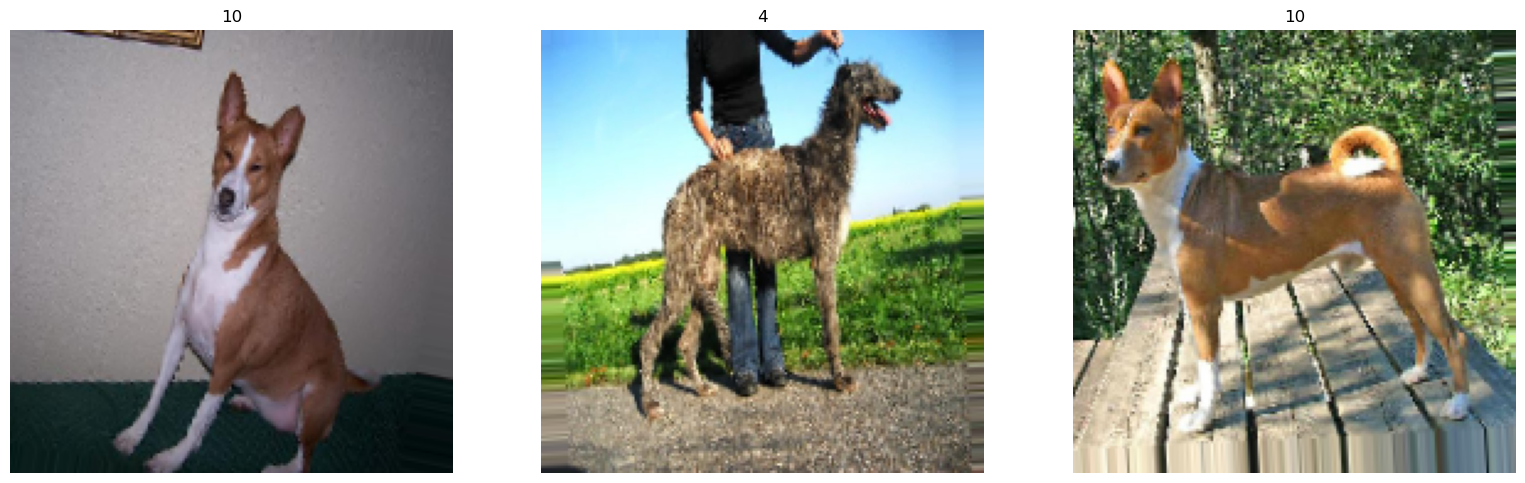

In [167]:
# Get one batch of images
images, labels = next(train_it)
plt.figure(figsize=(40, 10))


# Display the first 3 images
for i in range(3):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
    
plt.show()

## Sauvegarde des images pré-traitées
**It seems we have an imbalance class problem**

In [130]:
def save_preprocessed_images(generator, set_name):
    # Create a reverse mapping from class indices to breed names
    reverse_class_indices = {v: k for k, v in generator.class_indices.items()}
    for i in range(len(generator)):
        # Get a batch of images
        batch, labels = generator.next()
        # Get the class names of the current batch
        breed_names = [reverse_class_indices[np.argmax(label)] for label in labels]

        for j, (img, breed) in enumerate(zip(batch, breed_names)):
            # Create a directory for the breed if it doesn't exist
            breed_dir = os.path.join(processed_data_path, set_name, breed)
            os.makedirs(breed_dir, exist_ok=True)
            # Save the image
            img_path = os.path.join(breed_dir, f"{set_name}_{i}_{j}.jpg")
            save_img(img_path, img)

In [132]:
# Define the path to the directory where the preprocessed images will be saved
processed_data_path = "C:\\Users\\Lemel\\OPC-P6\\ProcessedImages"

In [135]:
# Save the training and validation images
#save_preprocessed_images(train_it, "train")
#save_preprocessed_images(val_it, "val")

## Class imbalance problem
**Part 1 After creating the new pre-processed pictures, we see that we have just 14 folders for the train set and 3 folders for the val set. So we are checking the class imbalance.** 

*Part 2 :There is no class imbalance problem so our problem does not come from our data or the model but perhaps from the bath we set manually : it's possible that some categories don't have enough images to form a complete batch (in our case, a batch of size 32), and these images might not get saved. To investigate this issue, we decide to make a modification in our function*

### Checking class imbalance

In [138]:
# Count the number of images per breed
image_counts = filtered_df['Breed'].value_counts()

# Print the counts
print(image_counts)

n02085936-Maltese_dog             252
n02088094-Afghan_hound            239
n02092002-Scottish_deerhound      232
n02112018-Pomeranian              219
n02107683-Bernese_mountain_dog    218
n02111889-Samoyed                 218
n02090721-Irish_wolfhound         218
n02086240-Shih-Tzu                214
n02111500-Great_Pyrenees          213
n02111129-Leonberg                210
n02110806-basenji                 209
n02097474-Tibetan_terrier         206
n02095889-Sealyham_terrier        202
n02108000-EntleBucher             202
n02096051-Airedale                202
Name: Breed, dtype: int64


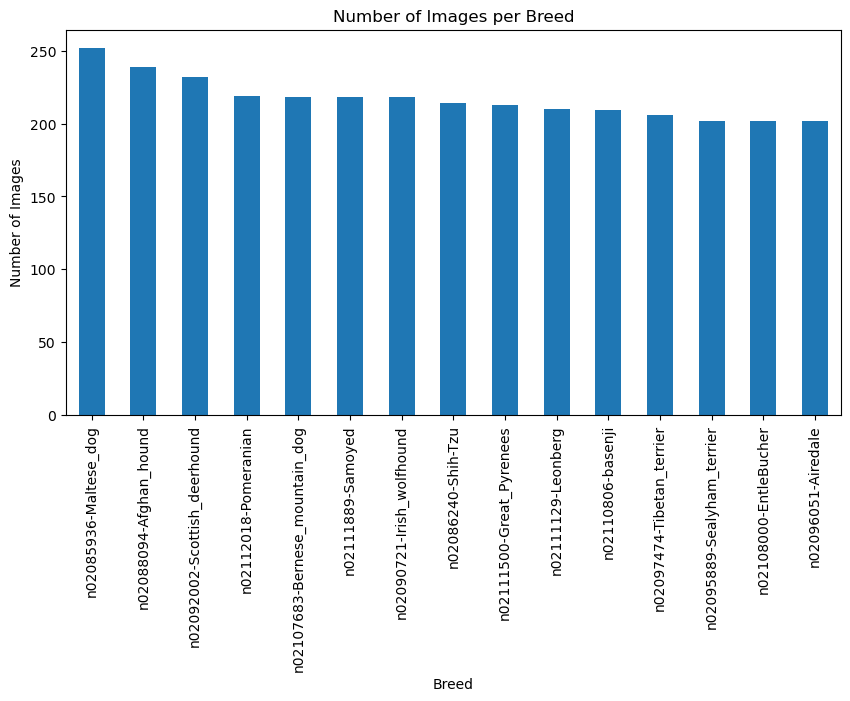

In [139]:
# Plot the image counts
image_counts.plot(kind='bar', figsize=(10, 5))
plt.title('Number of Images per Breed')
plt.xlabel('Breed')
plt.ylabel('Number of Images')
plt.show()

### Checking class-imbalance issue : Batch = 32
* Ce n'est pas un problème de la taille de Batch 

In [155]:
def save_preprocessed_images(generator, set_name):
    # Create a reverse mapping from class indices to breed names
    reverse_class_indices = {v: k for k, v in generator.class_indices.items()}

    for i in range(len(generator)):
        # Get a batch of images
        batch, labels = generator.next()
        # Get the class names of the current batch
        breed_names = [reverse_class_indices[np.argmax(label)] for label in labels]

        for j, (img, breed) in enumerate(zip(batch, breed_names)):
            # Create a directory for the breed if it doesn't exist
            breed_dir = os.path.join(processed_data_path, set_name, breed)
            try:
                os.makedirs(breed_dir, exist_ok=True)
            except Exception as e:
                print(f"Error creating directory {breed_dir}: {e}")
                continue

            # Save the image
            img_path = os.path.join(breed_dir, f"{set_name}_{i}_{j}.jpg")
            try:
                save_img(img_path, img)
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")

In [156]:
# Define the path to the directory where the preprocessed images will be saved
processed_data_path = "C:\\Users\\Lemel\\OPC-P6\\ProcessedImages_2"

In [157]:
# Save the training and validation images
#save_preprocessed_images(train_it, "train")
#save_preprocessed_images(val_it, "val")

In [158]:
def check_class_distribution(generator):
    # Create a reverse mapping from class indices to breed names
    reverse_class_indices = {v: k for k, v in generator.class_indices.items()}
    class_counts = {}

    for i in range(len(generator)):
        _, labels = generator.next()
        breed_names = [reverse_class_indices[np.argmax(label)] for label in labels]
        for breed in breed_names:
            class_counts[breed] = class_counts.get(breed, 0) + 1

    print(class_counts)

In [159]:
check_class_distribution(train_it)
check_class_distribution(val_it)

{'n02111500-Great_Pyrenees': 216, 'n02090721-Irish_wolfhound': 224, 'n02096051-Airedale': 199, 'n02108000-EntleBucher': 204, 'n02092002-Scottish_deerhound': 73, 'n02095889-Sealyham_terrier': 201, 'n02111889-Samoyed': 204, 'n02111129-Leonberg': 215, 'n02086240-Shih-Tzu': 217, 'n02107683-Bernese_mountain_dog': 222, 'n02110806-basenji': 205, 'n02097474-Tibetan_terrier': 204, 'n02112018-Pomeranian': 220}
{'n02085936-Maltese_dog': 252, 'n02088094-Afghan_hound': 239, 'n02092002-Scottish_deerhound': 159}


### Checking class-imbalance issue : train test split stratified

#### Train test split + Image data Generator 

In [168]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(filtered_df, stratify=filtered_df['Breed'], test_size=0.2)

In [212]:
# Initialize the ImageDataGenerator with more augmentations
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    zca_whitening=True,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    validation_split=0.2)  # use 20% of the data for validation

# Use flow_from_dataframe method
train_it_X = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col="Image",
    y_col="Breed",
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

val_it_Y = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=directory,
    x_col="Image",
    y_col="Breed",
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)

Found 2083 validated image filenames belonging to 15 classes.
Found 130 validated image filenames belonging to 15 classes.


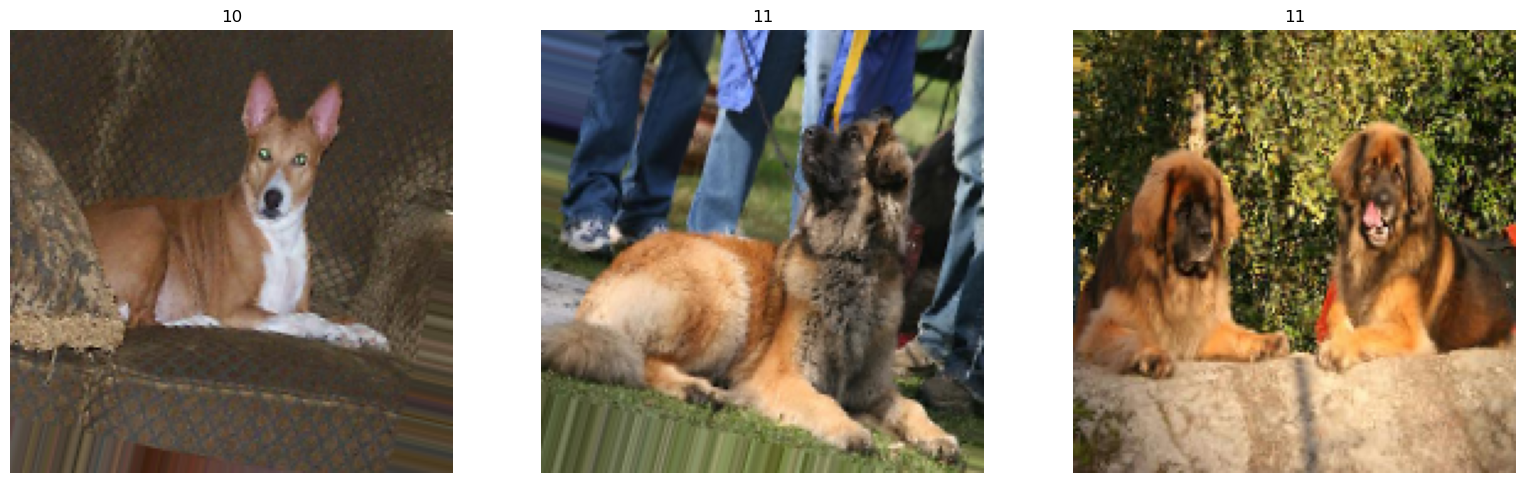

In [213]:
# Get one batch of images
images, labels = next(train_it_X)
plt.figure(figsize=(40, 10))


# Display the first 3 images
for i in range(3):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
    
plt.show()

In [174]:
# Define the path to the directory where the preprocessed images will be saved
processed_data_path = "C:\\Users\\Lemel\\OPC-P6\\ProcessedImages_3"

In [175]:
# Save the training and validation images
#save_preprocessed_images(train_it_X, "train")
#save_preprocessed_images(val_it_Y, "val")

In [176]:
check_class_distribution(train_it_X)
check_class_distribution(val_it_Y)

{'n02086240-Shih-Tzu': 140, 'n02110806-basenji': 120, 'n02097474-Tibetan_terrier': 127, 'n02096051-Airedale': 124, 'n02111889-Samoyed': 142, 'n02095889-Sealyham_terrier': 126, 'n02107683-Bernese_mountain_dog': 141, 'n02108000-EntleBucher': 141, 'n02111500-Great_Pyrenees': 144, 'n02111129-Leonberg': 142, 'n02090721-Irish_wolfhound': 142, 'n02088094-Afghan_hound': 156, 'n02085936-Maltese_dog': 163, 'n02112018-Pomeranian': 125, 'n02092002-Scottish_deerhound': 150}
{'n02110806-basenji': 11, 'n02096051-Airedale': 6, 'n02111129-Leonberg': 5, 'n02108000-EntleBucher': 8, 'n02111889-Samoyed': 6, 'n02097474-Tibetan_terrier': 9, 'n02088094-Afghan_hound': 12, 'n02111500-Great_Pyrenees': 14, 'n02107683-Bernese_mountain_dog': 6, 'n02092002-Scottish_deerhound': 11, 'n02085936-Maltese_dog': 13, 'n02090721-Irish_wolfhound': 8, 'n02095889-Sealyham_terrier': 11, 'n02086240-Shih-Tzu': 8, 'n02112018-Pomeranian': 2}


#### Class balance

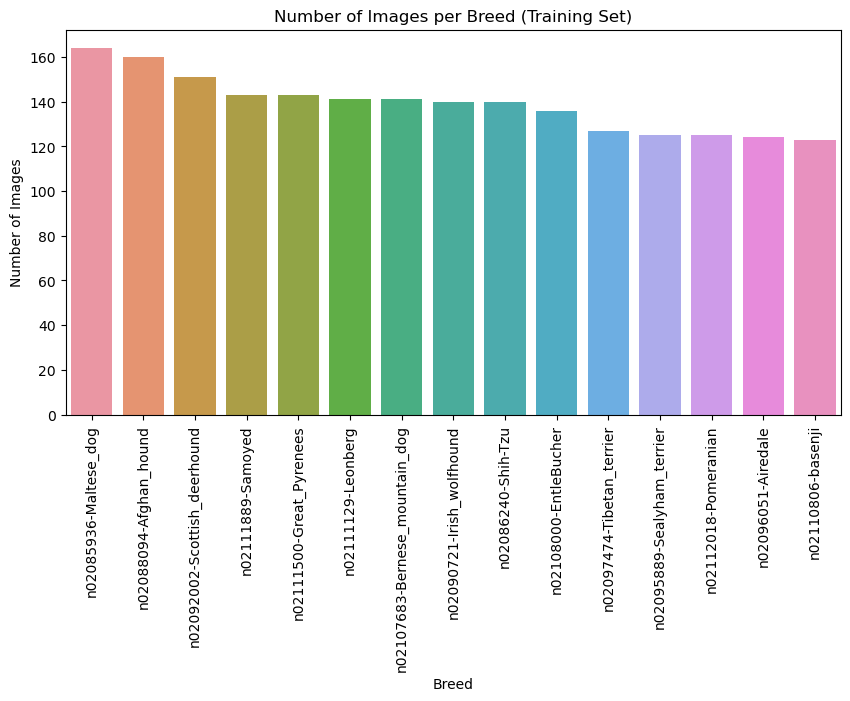

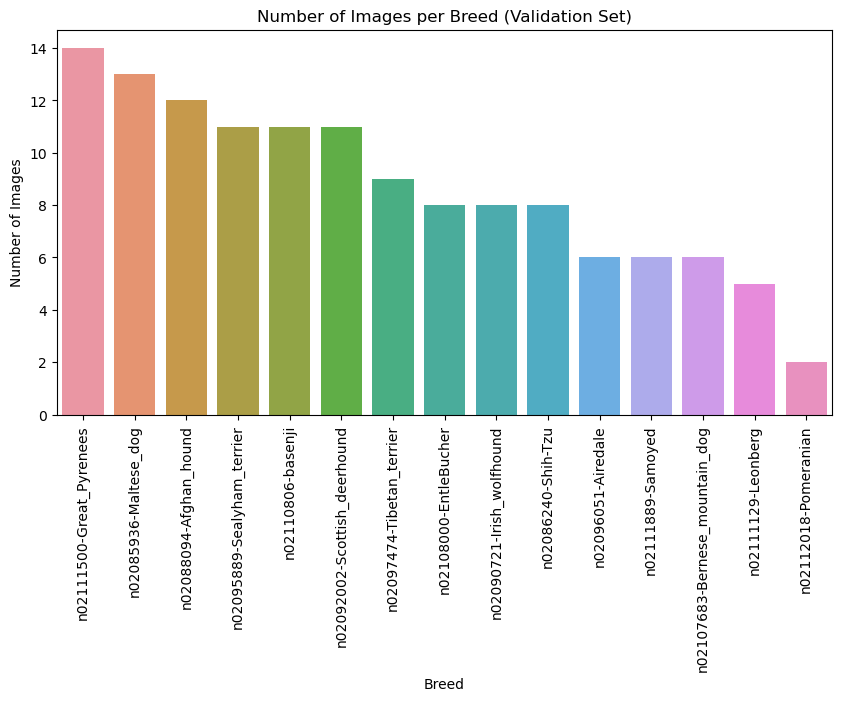

In [205]:
# Count the number of images per breed in train_it_X
image_counts_train_it_X = {}
for i in range(len(train_it_X.filenames)):
    breed = train_it_X.filenames[i].split('\\')[-2]
    if breed in image_counts_train_it_X:
        image_counts_train_it_X[breed] += 1
    else:
        image_counts_train_it_X[breed] = 1

# Count the number of images per breed in val_it_Y
image_counts_val_it_Y = {}
for i in range(len(val_it_Y.filenames)):
    breed = val_it_Y.filenames[i].split('\\')[-2]
    if breed in image_counts_val_it_Y:
        image_counts_val_it_Y[breed] += 1
    else:
        image_counts_val_it_Y[breed] = 1

# Create DataFrames for image counts
image_counts_train_it_X_df = pd.DataFrame({'Breed': list(image_counts_train_it_X.keys()), 'Count': list(image_counts_train_it_X.values())})
image_counts_val_it_Y_df = pd.DataFrame({'Breed': list(image_counts_val_it_Y.keys()), 'Count': list(image_counts_val_it_Y.values())})

# Sort the DataFrames by breed count
image_counts_train_it_X_df = image_counts_train_it_X_df.sort_values('Count', ascending=False)
image_counts_val_it_Y_df = image_counts_val_it_Y_df.sort_values('Count', ascending=False)

# Plot the image counts
plt.figure(figsize=(10, 5))
sns.barplot(x='Breed', y='Count', data=image_counts_train_it_X_df)
plt.title('Number of Images per Breed (Training Set)')
plt.xlabel('Breed')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Breed', y='Count', data=image_counts_val_it_Y_df)
plt.title('Number of Images per Breed (Validation Set)')
plt.xlabel('Breed')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# CNN training and hyperparamèters tuning

In [227]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = 'C:\\Users\\Lemel\\OPC-P6\\ProcessedImages_3\\train'
val_dir = 'C:\\Users\\Lemel\\OPC-P6\\ProcessedImages_3\\val'

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values

# Set batch size as per your requirement
batch_size = 32

# Load images from directories
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
)

Found 2083 images belonging to 15 classes.
Found 130 images belonging to 15 classes.


## First iteration 
Source oriinale  : https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

**We are setting up the architecture of your convolutional neural network (CNN). The CNN architecture has several layers: convolutional layers (Conv2D), pooling layers (MaxPooling2D), fully connected (dense) layers (Dense), and dropout layers (Dropout).**

- Conv2D layers are the main building block of a CNN. They perform a convolution operation, which essentially means they take an input, apply a filter (or kernel) to it, and produce an output (feature map). In this case, we filter 7x7 and 3x3 pixels.

- MaxPooling2D layers are used for downsampling the input, which helps to reduce overfitting and to decrease computational load by reducing the dimensionality.

- Flatten layer is used to convert the 2D matrices from the preceding layers into a 1D vector.

- Dense layers are fully connected layers, meaning each neuron in a layer receives input from all neurons of the previous layer. They're used in the later stages of the network, once the features have been extracted by the preceding layers.

- The input_shape parameter in the first Conv2D layer should match the dimensions of our images (height, width) and the number of color channels (3 for RGB images).

- In the final Dense layer, the softmax activation function outputs a probability distribution over the target classes, making it suitable for multi-class categorical predictions.

- The compile method is used to configure the model for training, we can specify the loss function, the optimizer, and the metrics.

- Finaly; we can use tf.distribute.Strategy to train it. We could also adding batch normalization layers, which can help to stabilize learning and reduce generalization error.

In [223]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# We adjust these values based on our pictures dimensions
img_height = 180
img_width = 180
num_channels = 3
num_classes = 15 # 15 breeds

# Define the model architecture
model = Sequential([
    Conv2D(filters=64, kernel_size=7, activation='relu', padding="SAME", input_shape=[img_height, img_width, num_channels]),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=256, kernel_size=3, activation='relu', padding="SAME"),
    Conv2D(filters=256, kernel_size=3, activation='relu', padding="SAME"),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax'),  # num_classes = number of categories in your case
])

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [228]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
66/66 [==============================] - 160s 2s/step - loss: 2.7734 - accuracy: 0.0715 - val_loss: 2.7048 - val_accuracy: 0.0923
Epoch 2/10
66/66 [==============================] - 159s 2s/step - loss: 2.7076 - accuracy: 0.0802 - val_loss: 2.7045 - val_accuracy: 0.0923
Epoch 3/10
66/66 [==============================] - 157s 2s/step - loss: 2.7328 - accuracy: 0.0783 - val_loss: 2.7018 - val_accuracy: 0.0923
Epoch 4/10
66/66 [==============================] - 156s 2s/step - loss: 2.7053 - accuracy: 0.0773 - val_loss: 2.7008 - val_accuracy: 0.0923
Epoch 5/10
66/66 [==============================] - 155s 2s/step - loss: 2.7059 - accuracy: 0.0773 - val_loss: 2.7010 - val_accuracy: 0.0923
Epoch 6/10
66/66 [==============================] - 155s 2s/step - loss: 2.7061 - accuracy: 0.0773 - val_loss: 2.6987 - val_accuracy: 0.0923
Epoch 7/10
66/66 [==============================] - 157s 2s/step - loss: 2.7061 - accuracy: 0.0768 - val_loss: 2.6980 - val_accuracy: 0.0923
Epoch 8/10
66

In [229]:
score = model.evaluate(validation_generator)

5/5 [==============================] - 2s 419ms/step - loss: 2.6983 - accuracy: 0.0923


## 2ème itération 
*Car notre modèle à une faible accuracy, nous nous inspirons du dernier modèle du notebook source*

In [230]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [231]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

with strategy.scope():
    # Define the model architecture
    model_2 = Sequential([
        Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[img_height, img_width, num_channels]),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.25),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),  # num_classes = number of categories in your case
    ])

    # Compile the model
    model_2.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [233]:
# Now we can train the model
history_2 = model_2.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
66/66 [==============================] - 118s 2s/step - loss: 3.4266 - accuracy: 0.1296 - val_loss: 2.7423 - val_accuracy: 0.0692
Epoch 2/10
66/66 [==============================] - 116s 2s/step - loss: 2.4346 - accuracy: 0.2880 - val_loss: 2.8194 - val_accuracy: 0.1000
Epoch 3/10
66/66 [==============================] - 113s 2s/step - loss: 1.8174 - accuracy: 0.4311 - val_loss: 3.5101 - val_accuracy: 0.1000
Epoch 4/10
66/66 [==============================] - 113s 2s/step - loss: 1.0172 - accuracy: 0.6923 - val_loss: 6.4567 - val_accuracy: 0.1077
Epoch 5/10
66/66 [==============================] - 114s 2s/step - loss: 0.5516 - accuracy: 0.8608 - val_loss: 4.8765 - val_accuracy: 0.0231
Epoch 6/10
66/66 [==============================] - 114s 2s/step - loss: 0.3261 - accuracy: 0.9265 - val_loss: 4.5486 - val_accuracy: 0.0462
Epoch 7/10
66/66 [==============================] - 114s 2s/step - loss: 0.1739 - accuracy: 0.9736 - val_loss: 4.0561 - val_accuracy: 0.0385
Epoch 8/10
66

In [234]:
score_2 = model_2.evaluate(validation_generator)

5/5 [==============================] - 1s 177ms/step - loss: 2.5437 - accuracy: 0.2231


In [235]:
from sklearn.metrics import classification_report, confusion_matrix

In [237]:
# true labels for the validation set
true_labels = validation_generator.classes

# Get the model's predictions
# This will give a 2D array with the probabilities for each class
predictions_prob = model_2.predict(validation_generator)

# To get the predicted labels, choose the class with the highest probability
predicted_labels = np.argmax(predictions_prob, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=validation_generator.class_indices.keys())
print(report)

# Generate a confusion matrix
matrix = confusion_matrix(true_labels, predicted_labels)

                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.03      0.08      0.05        13
            n02086240-Shih-Tzu       0.33      0.25      0.29         8
        n02088094-Afghan_hound       0.15      0.17      0.16        12
     n02090721-Irish_wolfhound       0.00      0.00      0.00         8
  n02092002-Scottish_deerhound       0.00      0.00      0.00        11
    n02095889-Sealyham_terrier       0.00      0.00      0.00        11
            n02096051-Airedale       0.00      0.00      0.00         6
     n02097474-Tibetan_terrier       0.00      0.00      0.00         9
n02107683-Bernese_mountain_dog       0.00      0.00      0.00         6
         n02108000-EntleBucher       0.00      0.00      0.00         8
             n02110806-basenji       0.00      0.00      0.00        11
            n02111129-Leonberg       0.00      0.00      0.00         5
      n02111500-Great_Pyrenees       0.22      0.14      0.17  

In [239]:
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print(f'Classification Report:\n {report}\n')
print(f'Global accuracy: {accuracy}\n')

Classification Report:
                                 precision    recall  f1-score   support

         n02085936-Maltese_dog       0.03      0.08      0.05        13
            n02086240-Shih-Tzu       0.33      0.25      0.29         8
        n02088094-Afghan_hound       0.15      0.17      0.16        12
     n02090721-Irish_wolfhound       0.00      0.00      0.00         8
  n02092002-Scottish_deerhound       0.00      0.00      0.00        11
    n02095889-Sealyham_terrier       0.00      0.00      0.00        11
            n02096051-Airedale       0.00      0.00      0.00         6
     n02097474-Tibetan_terrier       0.00      0.00      0.00         9
n02107683-Bernese_mountain_dog       0.00      0.00      0.00         6
         n02108000-EntleBucher       0.00      0.00      0.00         8
             n02110806-basenji       0.00      0.00      0.00        11
            n02111129-Leonberg       0.00      0.00      0.00         5
      n02111500-Great_Pyrenees       0.

## RandomSearch : tenter de résoudre l'over-fitting par une recherche d'hyperparamètres

*We are observing high validation loss compared to the training loss in the second iteration, which is a sign of overfitting. Overfitting happens when the model learns the training data too well and performs poorly on the unseen data (validation and test sets). This is can be addressed using regularization methods and hyperparameter tuning. We are goinf to using Keras Tuner.*  
**Nous utilisons les données des deux itérations précédentes dans cette recherche aléatoire afin qu'elle soit plus efficace vu le temps de ressource alloué**  

In [241]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from kerastuner.tuners import RandomSearch

In [242]:
# Hyperparameter search for number of filters, kernel size in Conv2D layers, dropout rate in Dropout layers, 
# Number of neurons in Dense layer and learning rate for Adam optimizer.

def build_model(hp):
    model = keras.models.Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                     activation='relu',
                     input_shape=(img_height,img_width,num_channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [243]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # number of different hyperparameter configurations to test
    executions_per_trial=3,  # number of trials per hyperparameter configuration
    directory='my_dir',
    project_name='helloworld')

In [244]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
learning_rate (C

In [245]:
# Provide your train and validation data generator to tuner's search method
tuner.search(train_generator,
             steps_per_epoch = train_generator.samples // batch_size,
             epochs = 3,
             validation_data = validation_generator,
             validation_steps = validation_generator.samples // batch_size)

Trial 1 Complete [00h 15m 28s]
val_accuracy: 0.057291666666666664

Best val_accuracy So Far: 0.057291666666666664
Total elapsed time: 00h 15m 28s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |96                |conv_1_filter
3                 |3                 |conv_1_kernel
0.3               |0.2               |dropout_1
32                |32                |conv_2_filter
5                 |5                 |conv_2_kernel
0.45              |0.25              |dropout_2
128               |64                |dense_1_units
0.3               |0.4               |dropout_3
0.001             |0.0001            |learning_rate

Epoch 1/3
65/65 [==============================] - 139s 2s/step - loss: 6.2190 - accuracy: 0.1102 - val_loss: 2.7587 - val_accuracy: 0.0234
Epoch 2/3
65/65 [==============================] - 139s 2s/step - loss: 2.7138 - accuracy: 0.0936 - val_loss: 6.2998 - val_accuracy: 0.0859
Epoch 3/3
65/65 [====================

KeyboardInterrupt: 

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

## 4ème itération : ajouter régularisation et early stopping  
C'est mieux mais j'ai mis 10 epochs au lieu de 100 par rapport aux ressources que cela demande donc je dois faire retourner car pas d'effet de l'earny stopping. 

In [246]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [247]:
# Model 3
model_3 = Sequential([
    Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[img_height, img_width, num_channels]),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax"),  # num_classes = number of categories in your case
])

In [249]:
# Compile the model
model_3.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model_3.fit(train_generator, 
                      steps_per_epoch=train_generator.samples // batch_size, 
                      validation_data=validation_generator, 
                      validation_steps=validation_generator.samples // batch_size, 
                      epochs=10,
                      callbacks=[early_stopping])

Epoch 1/10
65/65 [==============================] - 126s 2s/step - loss: 8.2064 - accuracy: 0.1628 - val_loss: 7.7319 - val_accuracy: 0.1484
Epoch 2/10
65/65 [==============================] - 124s 2s/step - loss: 7.8536 - accuracy: 0.1667 - val_loss: 6.8165 - val_accuracy: 0.0703
Epoch 3/10
65/65 [==============================] - 124s 2s/step - loss: 8.3065 - accuracy: 0.1745 - val_loss: 8.6161 - val_accuracy: 0.0938
Epoch 4/10
65/65 [==============================] - 124s 2s/step - loss: 8.2929 - accuracy: 0.1809 - val_loss: 7.7173 - val_accuracy: 0.1172
Epoch 5/10
65/65 [==============================] - 124s 2s/step - loss: 8.1205 - accuracy: 0.2019 - val_loss: 7.4468 - val_accuracy: 0.1562
Epoch 6/10
65/65 [==============================] - 126s 2s/step - loss: 7.5248 - accuracy: 0.1892 - val_loss: 6.5252 - val_accuracy: 0.1719
Epoch 7/10
65/65 [==============================] - 125s 2s/step - loss: 7.2459 - accuracy: 0.2067 - val_loss: 6.5774 - val_accuracy: 0.1172
Epoch 8/10
65

In [250]:
score_3 = model_3.evaluate(validation_generator)

5/5 [==============================] - 1s 219ms/step - loss: 6.7290 - accuracy: 0.2538


In [251]:
# true labels for the validation set
true_labels = validation_generator.classes

# Get the model's predictions
predictions_prob = model_3.predict(validation_generator)

# To get the predicted labels, choose the class with the highest probability
predicted_labels = np.argmax(predictions_prob, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=validation_generator.class_indices.keys())
print(report)

# Generate a confusion matrix
matrix = confusion_matrix(true_labels, predicted_labels)

                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.11      0.23      0.15        13
            n02086240-Shih-Tzu       0.12      0.12      0.12         8
        n02088094-Afghan_hound       0.00      0.00      0.00        12
     n02090721-Irish_wolfhound       0.00      0.00      0.00         8
  n02092002-Scottish_deerhound       0.08      0.09      0.09        11
    n02095889-Sealyham_terrier       0.00      0.00      0.00        11
            n02096051-Airedale       0.00      0.00      0.00         6
     n02097474-Tibetan_terrier       0.15      0.33      0.21         9
n02107683-Bernese_mountain_dog       0.00      0.00      0.00         6
         n02108000-EntleBucher       0.00      0.00      0.00         8
             n02110806-basenji       0.00      0.00      0.00        11
            n02111129-Leonberg       0.00      0.00      0.00         5
      n02111500-Great_Pyrenees       0.00      0.00      0.00  

In [252]:
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print(f'Classification Report:\n {report}\n')
print(f'Global accuracy: {accuracy}\n')

Classification Report:
                                 precision    recall  f1-score   support

         n02085936-Maltese_dog       0.11      0.23      0.15        13
            n02086240-Shih-Tzu       0.12      0.12      0.12         8
        n02088094-Afghan_hound       0.00      0.00      0.00        12
     n02090721-Irish_wolfhound       0.00      0.00      0.00         8
  n02092002-Scottish_deerhound       0.08      0.09      0.09        11
    n02095889-Sealyham_terrier       0.00      0.00      0.00        11
            n02096051-Airedale       0.00      0.00      0.00         6
     n02097474-Tibetan_terrier       0.15      0.33      0.21         9
n02107683-Bernese_mountain_dog       0.00      0.00      0.00         6
         n02108000-EntleBucher       0.00      0.00      0.00         8
             n02110806-basenji       0.00      0.00      0.00        11
            n02111129-Leonberg       0.00      0.00      0.00         5
      n02111500-Great_Pyrenees       0.

# Transfert learning
Source : https://www.tensorflow.org/tutorials/generative/style_transfer?hl=fr 
https://www.kaggle.com/code/michaelfumery/computer-vision-cnn-stanford-dogs-dataset
*Nous allosn tenter d'augmenter le nombre d'images pour améliorer les performances de notre modèle grâce au transfert learning*
  
  **We have choosen the Xception model car il demande  moins de ressources**

## 1er essai 

In [253]:
from tensorflow.keras.applications import Xception

In [254]:
# Load the pre-trained Xception model without the top (classification) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

83697664/83683744 [==============================] - 9s 0us/step


In [255]:
# Freeze the layers of the pre-trained model
#  This allows you to use the pre-trained model as a feature extractor and focus on training the new classification layers.
for layer in base_model.layers:
    layer.trainable = False

In [256]:
# Add new classification layers on top
model_tf = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [257]:
# Compile the model
model_tf.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [258]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=10)

Epoch 1/10
65/65 [==============================] - 152s 2s/step - loss: 2.7054 - accuracy: 0.0765 - val_loss: 2.6964 - val_accuracy: 0.0938
Epoch 2/10
65/65 [==============================] - 153s 2s/step - loss: 2.7045 - accuracy: 0.0780 - val_loss: 2.6978 - val_accuracy: 0.1016
Epoch 3/10
65/65 [==============================] - 156s 2s/step - loss: 2.7041 - accuracy: 0.0809 - val_loss: 2.6970 - val_accuracy: 0.0938
Epoch 4/10
65/65 [==============================] - 154s 2s/step - loss: 2.7045 - accuracy: 0.0761 - val_loss: 2.6960 - val_accuracy: 0.0938
Epoch 5/10
65/65 [==============================] - 153s 2s/step - loss: 2.7051 - accuracy: 0.0736 - val_loss: 2.6980 - val_accuracy: 0.1016
Epoch 6/10
65/65 [==============================] - 153s 2s/step - loss: 2.7047 - accuracy: 0.0819 - val_loss: 2.6960 - val_accuracy: 0.0938
Epoch 7/10
65/65 [==============================] - 157s 2s/step - loss: 2.7065 - accuracy: 0.0780 - val_loss: 2.6964 - val_accuracy: 0.1016
Epoch 8/10
65

In [259]:
score = model.evaluate(validation_generator)

5/5 [==============================] - 2s 424ms/step - loss: 2.6979 - accuracy: 0.0923


In [260]:
# true labels for the validation set
true_labels = validation_generator.classes

# Get the model's predictions
predictions_prob = model.predict(validation_generator)

# To get the predicted labels, choose the class with the highest probability
predicted_labels = np.argmax(predictions_prob, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=validation_generator.class_indices.keys())
print(report)

# Generate a confusion matrix
matrix = confusion_matrix(true_labels, predicted_labels)

                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.00      0.00      0.00        13
            n02086240-Shih-Tzu       0.00      0.00      0.00         8
        n02088094-Afghan_hound       0.09      1.00      0.17        12
     n02090721-Irish_wolfhound       0.00      0.00      0.00         8
  n02092002-Scottish_deerhound       0.00      0.00      0.00        11
    n02095889-Sealyham_terrier       0.00      0.00      0.00        11
            n02096051-Airedale       0.00      0.00      0.00         6
     n02097474-Tibetan_terrier       0.00      0.00      0.00         9
n02107683-Bernese_mountain_dog       0.00      0.00      0.00         6
         n02108000-EntleBucher       0.00      0.00      0.00         8
             n02110806-basenji       0.00      0.00      0.00        11
            n02111129-Leonberg       0.00      0.00      0.00         5
      n02111500-Great_Pyrenees       0.00      0.00      0.00  

## 2ème essai
**Beaucoup de classification matrices sont fausses car shuffle = True  
Pour obtenir les véritables étiquettes (y_true) et les prédictions (y_pred), nous devons parcourir le générateur de validation.  
Mais j'ai compris qu'à la fin**
  
  source : https://www.kaggle.com/code/michaelfumery/computer-vision-cnn-stanford-dogs-dataset

In [268]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [269]:
# Define constants
img_height = 180
img_width = 180
num_channels = 3
batch_size = 32
num_classes = 15  #
num_breeds = num_classes  #  num_breeds and num_classes are same

In [270]:
# Define pretrained Xception model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(img_height, img_width, num_channels)
)

In [271]:
# Freeze layers of pretrained model
for layer in xception_model.layers:
    layer.trainable = False

In [272]:
# Define new layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
predictions = Dense(num_breeds, activation='softmax')(base_output)

In [273]:
# Define new model
my_xcept_model = Model(inputs=xception_model.input, outputs=predictions)
my_xcept_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [274]:
# Train the model
history_xcept = my_xcept_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) / 32,
    epochs=20,
    verbose=2
)

Epoch 1/20
2/2 - 7s - loss: 2.5230 - accuracy: 0.2396 - val_loss: 1.8132 - val_accuracy: 0.4769 - 7s/epoch - 3s/step
Epoch 2/20
2/2 - 4s - loss: 1.7340 - accuracy: 0.5208 - val_loss: 1.2478 - val_accuracy: 0.6846 - 4s/epoch - 2s/step
Epoch 3/20
2/2 - 4s - loss: 1.1267 - accuracy: 0.7083 - val_loss: 0.8812 - val_accuracy: 0.7615 - 4s/epoch - 2s/step
Epoch 4/20
2/2 - 4s - loss: 0.9236 - accuracy: 0.7164 - val_loss: 0.6787 - val_accuracy: 0.7923 - 4s/epoch - 2s/step
Epoch 5/20
2/2 - 4s - loss: 0.6714 - accuracy: 0.7917 - val_loss: 0.6133 - val_accuracy: 0.7769 - 4s/epoch - 2s/step
Epoch 6/20
2/2 - 4s - loss: 0.7808 - accuracy: 0.7917 - val_loss: 0.5289 - val_accuracy: 0.8231 - 4s/epoch - 2s/step
Epoch 7/20
2/2 - 4s - loss: 0.6087 - accuracy: 0.8125 - val_loss: 0.4784 - val_accuracy: 0.8308 - 4s/epoch - 2s/step
Epoch 8/20
2/2 - 5s - loss: 0.6652 - accuracy: 0.8125 - val_loss: 0.4754 - val_accuracy: 0.8077 - 5s/epoch - 2s/step
Epoch 9/20
2/2 - 4s - loss: 0.5595 - accuracy: 0.8229 - val_loss

In [275]:
# Predict classes
y_pred = my_xcept_model.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=-1)

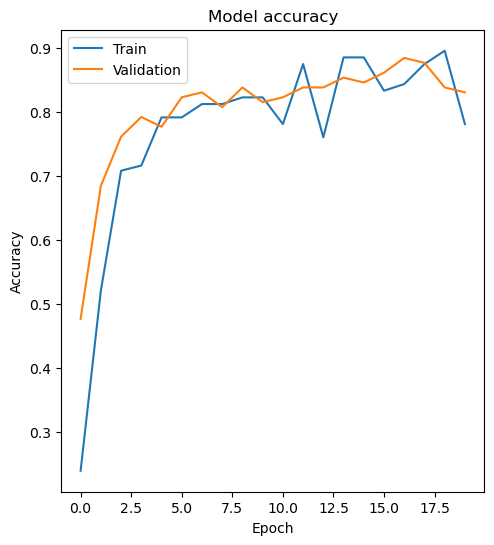

In [276]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_xcept.history['accuracy'])
plt.plot(history_xcept.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

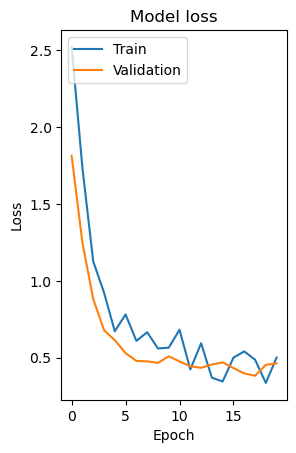

In [277]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_xcept.history['loss'])
plt.plot(history_xcept.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Found 130 images belonging to 15 classes.
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.58      0.88      0.70         8
           2       0.75      0.75      0.75        12
           3       0.67      0.75      0.71         8
           4       0.89      0.73      0.80        11
           5       1.00      0.64      0.78        11
           6       0.67      1.00      0.80         6
           7       1.00      0.56      0.71         9
           8       0.62      0.83      0.71         6
           9       1.00      0.75      0.86         8
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00         5
          12       0.74      1.00      0.85        14
          13       1.00      0.67      0.80         6
          14       1.00      1.00      1.00         2

    accuracy                           0.82       130
   macro avg       0.86      0.83     

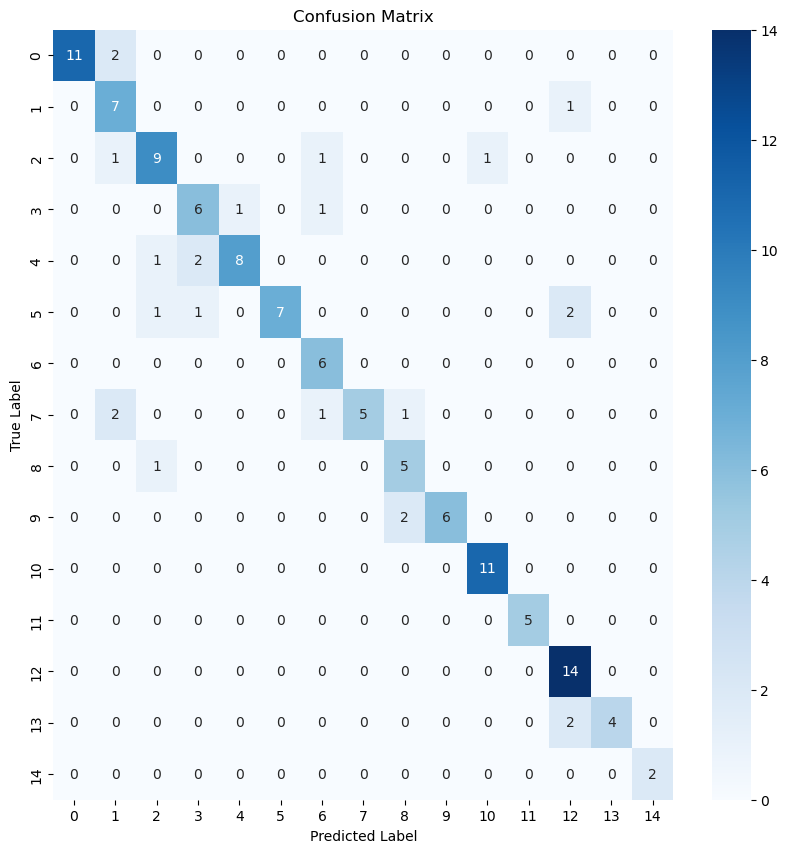

In [281]:
# Recreate the validation generator with shuffle = False
validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true = validation_generator.classes

# Predict the classes
predictions = my_xcept_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the classification report
print(classification_report(y_true, y_pred))


# Objectifs 
